In [206]:
########## Block 1 ############## <-- Please refer this block number when you ask questions
import numpy as np
# package for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# scikit-learn: machine learning in Python
# https://scikit-learn.org/stable/tutorial/basic/tutorial.html
# In this example, we are using the principal component analysis 
# and the Gaussian process regression as implemented in sklearn.
# Detailed documentation of these modules:
# Principal component analysis (PCA): 
# https://scikit-learn.org/stable/modules/decomposition.html
# Gaussian process gressor (GPR)):
# https://scikit-learn.org/stable/modules/gaussian_process.html
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import \
     GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels

# suppression warning messages
import warnings
warnings.filterwarnings('ignore')

# some plot settings, not important
fontsize  = 12
plt.rcdefaults()
plt.rcParams.update({
    'font.size': fontsize,
    'legend.fontsize': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': fontsize,
    'ytick.labelsize': fontsize,
    'axes.formatter.limits': (-5, 5),
    'axes.spines.top': True,
    'axes.spines.right': True,
    'legend.frameon': False,
    'image.cmap': 'Blues',
    'image.interpolation': 'none',
})

# Simple Principal Component Analysis (PCA) example

Some high dimensional data labeled by $x_i$($i=1,\cdots 20$) is actually generate from a function with only three degress of freedom, plus some noise.

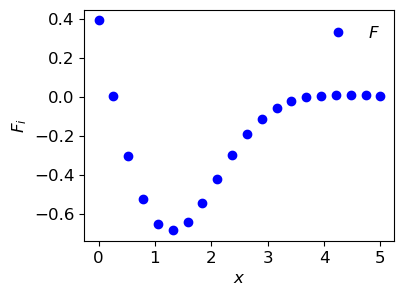

In [352]:
# First, three features
def F(x,a,b,c):
    return a*np.exp(-x)+b*np.exp(-.5*(x-c)**2)+np.random.normal(0,1e-5,len(x))
x = np.linspace(0,5,20)
fig, ax = plt.subplots(1,1,figsize=(4,3))
ax.plot(x, F(x, 1,-1,1), 'bo', label=r'$F$')
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$F_i$")
ax.legend()

In [353]:
Nsamples=100
A = np.random.normal(0,1,Nsamples)
B = np.random.normal(0,1,Nsamples)
C = np.random.normal(2.5,1,Nsamples)
Data = np.array([F(x, a, b,c) for a,b,c in zip(A,B,C)])

Text(0, 0.5, 'Final singal $F(x)$\n for each choice of $a,b,c$')

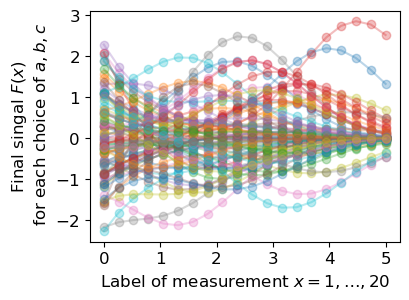

In [354]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
for it in Data:
    ax.plot(x, it, 'o-', alpha=.3)
ax.set_xlabel(r"Label of measurement $x=1,\dots, 20$")
ax.set_ylabel(r"Final singal $F(x)$"+"\n for each choice of $a,b,c$")

It looks that for we have 20 outputs, and each of them depends on the inputs $a,b,c$. However, deep down we know many of the outputs are correlated, and we only put in three independent components into the singal, so there should be a way to express the variation of the 20 outputs using fewer degree-of-freedom.

In [355]:
# This class take care most of the PCA functionalities
class Standardlization_PCA:
    def __init__(self, data, Npc):
        self.npc = Npc
        self.scaler = StandardScaler(copy=True)
        self.pca = PCA(copy=True, whiten=True, svd_solver='full')

        # Store the first Npc tranformed observables
        self.TransformedObs = self.pca.fit_transform(self.scaler.fit_transform(data))[:,:Npc]
        # Features of each PC
        self.Features = self.pca.components_
        # The transformation matrix from PC to Physical space
        self.TransformationMatrix = (np.sqrt(self.pca.explained_variance_[:Npc])\
                                    * self.pca.components_[:Npc,:].T).T \
                                    * self.scaler.scale_

        A = (np.sqrt(self.pca.explained_variance_[Npc:])\
            * self.pca.components_[Npc:,:].T).T \
            * self.scaler.scale_
        self.ResidualCov = np.dot(A.T*1., A)
        # cumulative sum of the explained variance
        self.CumulativeVariance = np.cumsum(self.pca.explained_variance_ratio_)
    def PC2Obs(self, PCs):
        return np.dot(PCs, self.TransformationMatrix) + self.scaler.mean_
    def PCcov2Obscov(self, PCcov, with_truncation_err=True):
        results = np.matmul(self.TransformationMatrix.T*PCcov, self.TransformationMatrix)
        if with_truncation_err:
            return results+self.ResidualCov
        else:
            return results

In [356]:
mypca = Standardlization_PCA(Data, Npc=3)

Linear correlation coefficients:  1.3472703696322728e-16


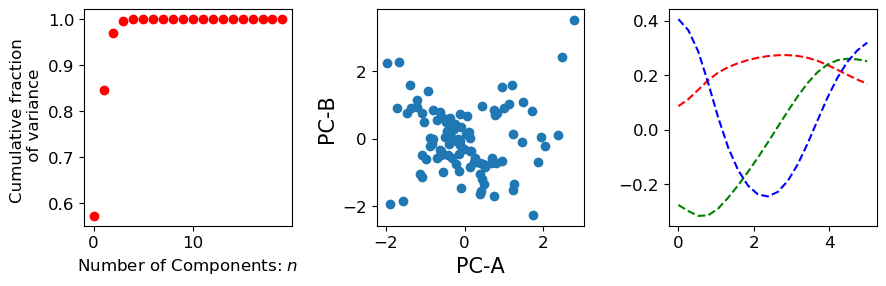

In [357]:
########## Block 17 ###########################
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Q1: Which PCs are important?
# Q2: What PCs look like?
# Q3: Are they linealy uncorrelated?
# Q4: Are their residue non-linear correlation?
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(9,3))

# Subplot 1: plot the cumulative variance contained in the first 
#            n principle components
ax1.plot(mypca.CumulativeVariance,'ro')
ax1.set_xlabel(r'Number of Components: $n$')
ax1.set_ylabel('Cumulative fraction \n of variance')

# Subplot 2: plot the 2D scattered plot of any two PCs
#            Check the covariance between them, are they small?
#            Is there some non-linear structure in the plot?
Z1 = mypca.TransformedObs[:, 0]
Z2 = mypca.TransformedObs[:, 1]
ax2.scatter(Z1, Z2)
cov = np.cov(Z1, Z2)
print("Linear correlation coefficients: ", 
      cov[1,0]/np.sqrt(cov[0,0]*cov[1,1]))
ax2.set_xlabel('PC-A', fontsize=15)
ax2.set_ylabel('PC-B', fontsize=15)

# Subplot 3-4: plot the first few pinciple components
#              a new basis for parametrzing the D.o.F
#              present in the observables.
for i, (it, color) in \
        enumerate(zip(mypca.Features, 'rgb')):
    ax3.plot(x,it, '--', color=color, label='PC {}'.format(i+1))
plt.tight_layout(True)

Go back to increase the nosie level in the data and repeat, see what happens.

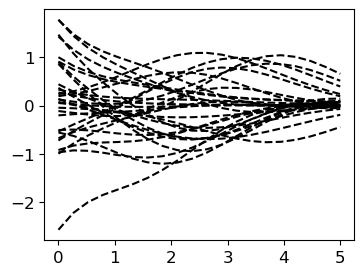

In [358]:
fig, ax = plt.subplots(1,1,figsize=(4,3))
PC1, PC2 = mypca.Features[:2]
Z1 = mypca.TransformedObs[:, 0]
Z2 = mypca.TransformedObs[:, 1]
Z3 = mypca.TransformedObs[:, 2]
for i in range(30):
    ax.plot(x, mypca.PC2Obs([Z1[i], Z2[i], Z3[i]]),'k--')